In [153]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from scipy.stats import uniform

# Classifiers:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

Load data, reshape X, and split into training, testing and validation data

In [159]:
y = np.load('MNIST-labels.npy')
X = np.load('MNIST-images.npy')

X = np.where(X<175,0,X) # replace noise in data with 0
X= X.reshape(X.shape[0], 576) #transform to vector
center_function = lambda x: x - x.mean()
X = center_function(X) # center the data, needed for PCA, but does not impact result if pca is not used

X_train,X_test_val,y_train,y_test_val = train_test_split(X, y, test_size=0.3, random_state = 42)
X_test,X_val,y_test,y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state = 42)

pca = PCA(n_components=35)

pca.fit(X_train) # Have to fit on training data to avoid learning test/val data
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)

potential_models = pd.DataFrame(columns=['Classifier name','Accuracy score','F1 score','Classifier object'])

Resample

In [126]:
#create two different dataframe of majority and minority class 
# X_majority = X_train[(y_train==3)] 
# X_minority = X_train[(y_train==8)] 



# X_remaining = X_train[(y_train!=3)]
# y_remaining = y_train[(y_train!=3)]
# average_amount = len(y_remaining)//10
# X_majority_downsampled = resample(X_majority, replace=True, n_samples= average_amount, random_state=42) 
# y_majority_downsampled = np.full(X_majority_downsampled.shape[0],3,dtype='int64')

# X_remaining = X_train[(y_train!=8)]
# y_remaining = y_train[(y_train!=8)]

# average_amount = len(y_remaining[(y_remaining!=3)])//10 # We create this so we can resample to the average amount of occorences of labels
# X_minority_upsampled = resample(X_minority, replace=True, n_samples= average_amount, random_state=42) 
# y_minority_upsampled = np.full(X_minority_upsampled.shape[0],8,dtype='int64')

# X_train= np.concatenate([X_remaining, X_minority_upsampled,X_majority_downsampled])
# y_train= np.concatenate([y_remaining, y_minority_upsampled,y_majority_downsampled])

# X_train= np.concatenate([X_remaining, X_minority_upsampled])
# y_train= np.concatenate([y_remaining, y_minority_upsampled])

# rg = np.arange(0,11)
# labels = pd.DataFrame(y_train).value_counts().sort_index().values
# fig = plt.figure()
# plt.xticks(rg)
# plt.bar(rg,labels) # Using bar because histogram combined columns 9 and 10
# plt.title('Distribution of labels in training data')
# plt.xlabel('Labels')
# plt.ylabel('Amount')
# plt.show()

Function for evaltuating a given classifier. Currently we do this by checking the accuracy score and by plotting the confusion matrix 

In [127]:
def plot_c_matrix(clf, classifier_name,f1_score):
    disp = ConfusionMatrixDisplay.from_estimator(
            clf,
            X_val,
            y_val,
            display_labels=np.arange(0,11),
            cmap=plt.cm.Blues,
            include_values = False,
            normalize='true',
        )
    disp.ax_.set_title("Confusion matrix for " + str(classifier_name) +"  on validation data")
    plt.text(-4, 1, f'F1: {str(round(f1_score,3))}', backgroundcolor = 'orange', fontsize = 10)
    plt.show()

def evaluate_classifier(clf,classifier_name):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_val)
    accuracy = metrics.accuracy_score(y_val,y_pred)
    f1_score = metrics.f1_score(y_val,y_pred, average='macro')
    
    plot_c_matrix(clf,classifier_name,f1_score)

    current_accuracy_dict = {
    'Classifier name' : [classifier_name],
    'Accuracy score' : [accuracy],
    'F1 score' : [f1_score],
    'Classifier object' : [clf]
    }
    current_accuracy_df = pd.DataFrame(current_accuracy_dict)
    return current_accuracy_df

Decision tree classifier:

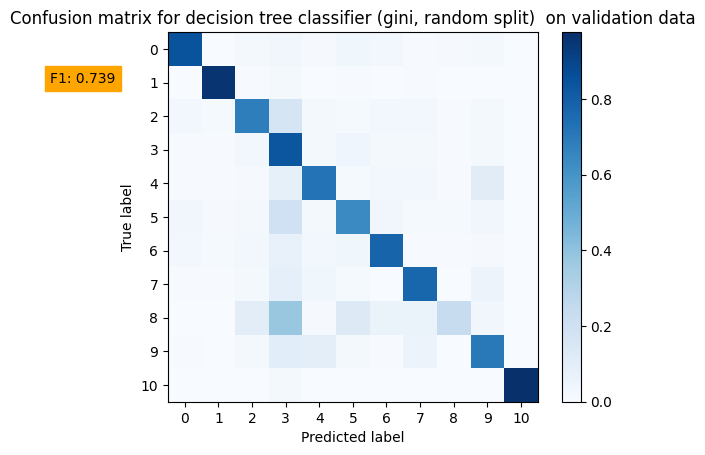

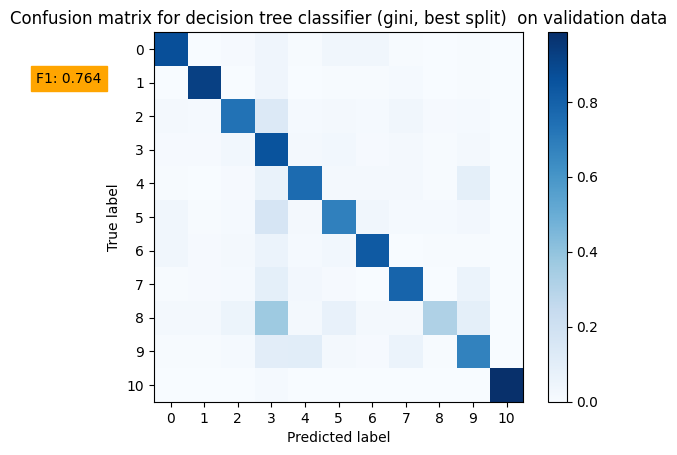

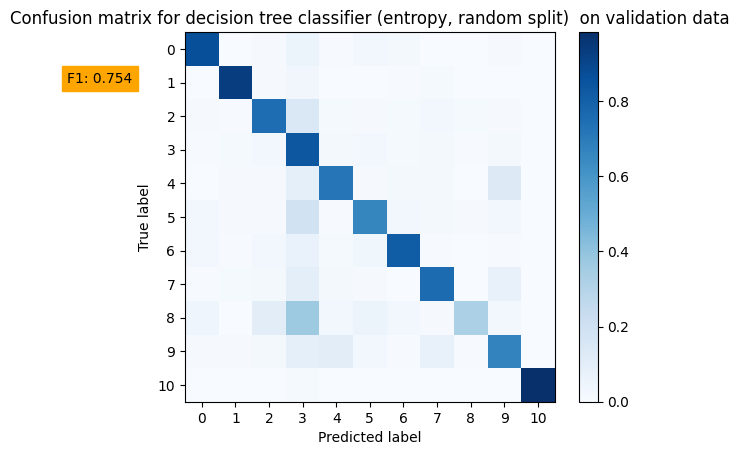

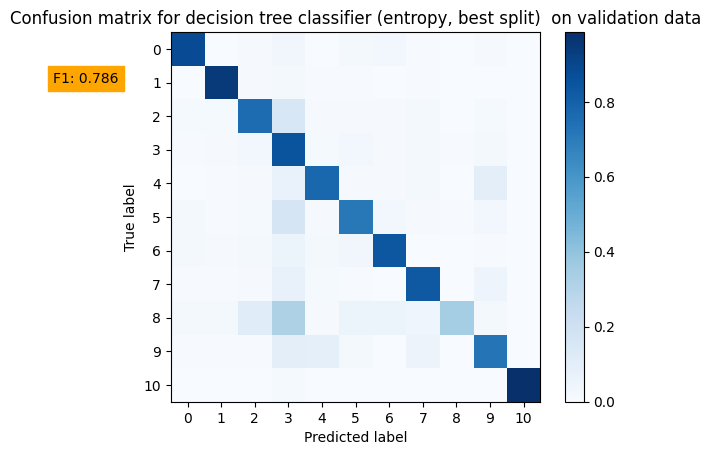

In [128]:
dtc = DecisionTreeClassifier(splitter='random', random_state=1)
dtc_accuracy = evaluate_classifier(dtc,"decision tree classifier (gini, random split)")
potential_models = pd.concat([potential_models, dtc_accuracy],ignore_index=True)

dtc = DecisionTreeClassifier(splitter='best', random_state=1)
dtc_accuracy = evaluate_classifier(dtc,"decision tree classifier (gini, best split)")
potential_models = pd.concat([potential_models, dtc_accuracy],ignore_index=True)

dtc = DecisionTreeClassifier(splitter='random', criterion='entropy', random_state=1)
dtc_accuracy = evaluate_classifier(dtc,"decision tree classifier (entropy, random split)")
potential_models = pd.concat([potential_models, dtc_accuracy],ignore_index=True)

dtc = DecisionTreeClassifier(splitter='best', criterion='entropy', random_state=1)
dtc_accuracy = evaluate_classifier(dtc,"decision tree classifier (entropy, best split)")
potential_models = pd.concat([potential_models, dtc_accuracy],ignore_index=True)

K nearest neighbors:

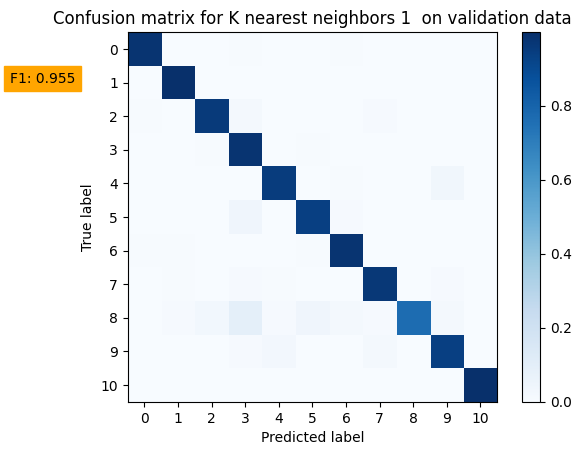

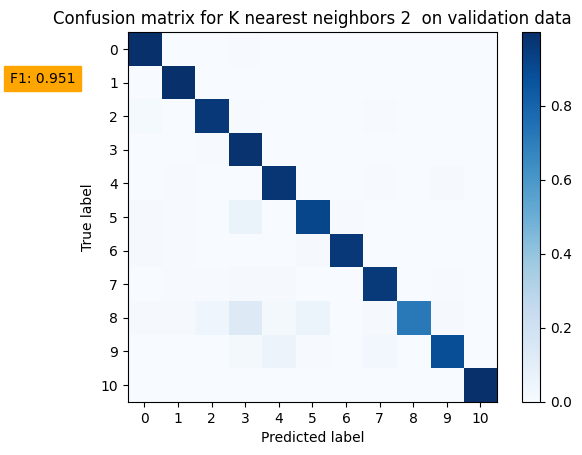

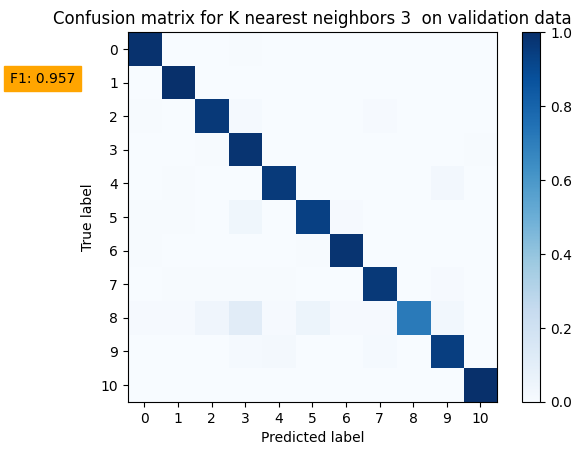

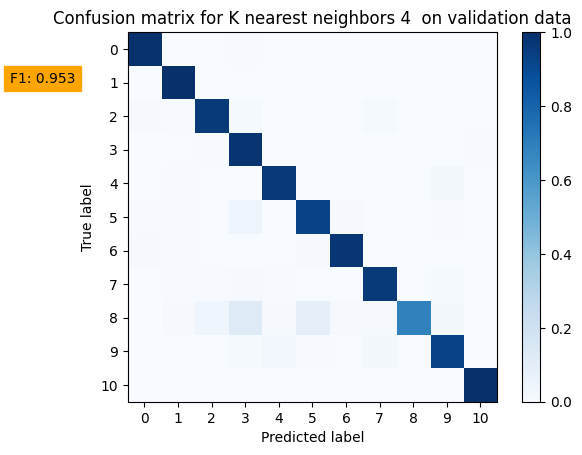

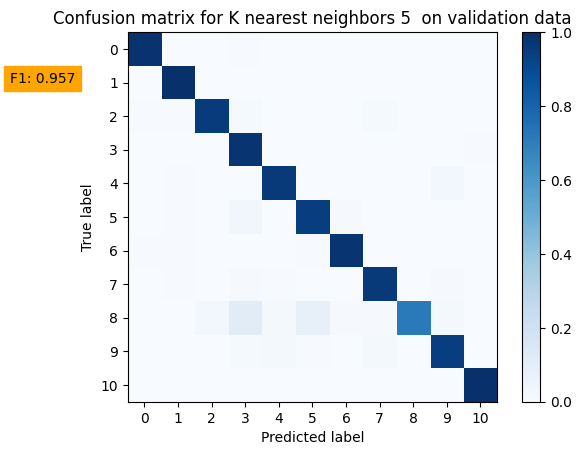

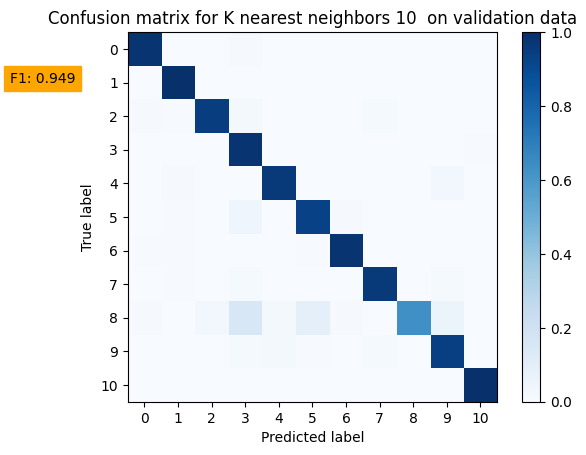

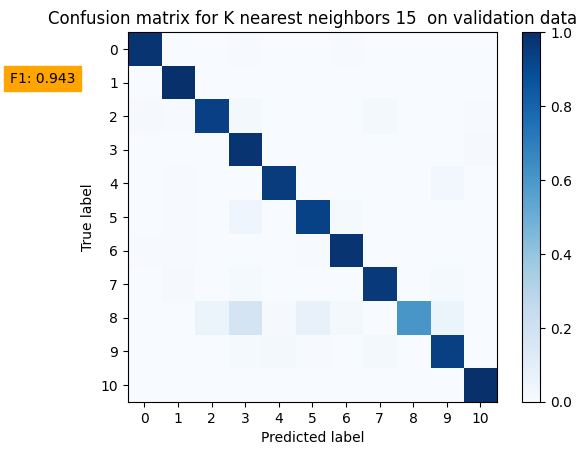

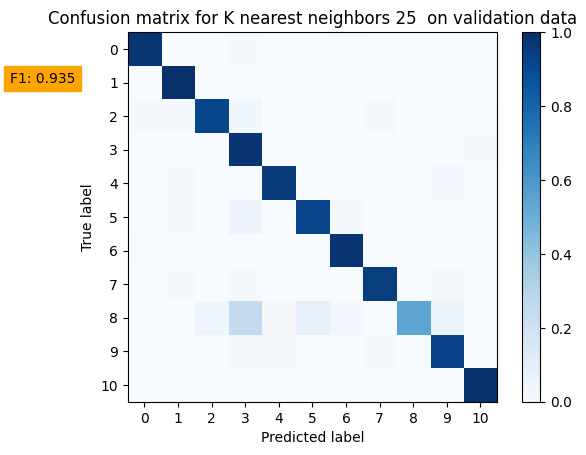

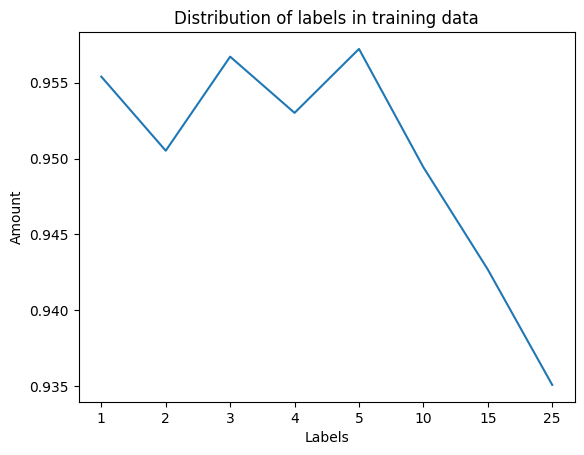

In [160]:
ks = [1,2,3,4,5,10,15,25]
neighbour_scores = []

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn_accuracy = evaluate_classifier(knn,'K nearest neighbors '+str(k))
    potential_models = pd.concat([potential_models,knn_accuracy],ignore_index=True)
    neighbour_scores.append(knn_accuracy['F1 score'][0])
    
x_values = ['1','2','3','4','5','10','15','25']
fig = plt.figure()
plt.xticks(ticks=np.arange(0,len(x_values)),labels=x_values)
plt.plot(x_values,neighbour_scores) # Using bar because histogram combined columns 9 and 10
plt.title('Distribution of labels in training data')
plt.xlabel('Labels')
plt.ylabel('Amount')
plt.show()


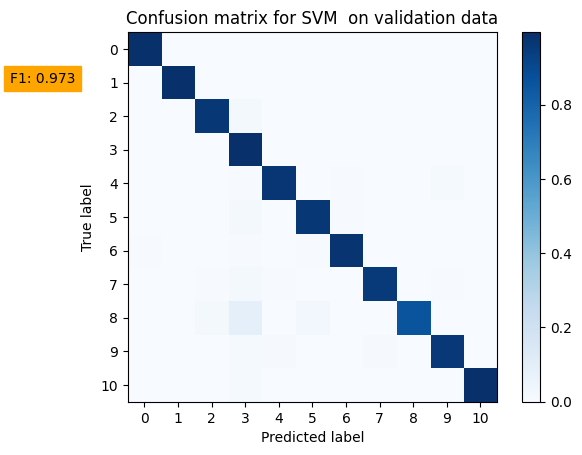

In [133]:
kernels = ['rbf']#['linear', 'poly', 'rbf', 'sigmoid']
# for kernel in kernels:
    # svm= SVC(random_state=1,kernel=kernel, class_weight='balanced',degree=1)
#     svm_accuracy = evaluate_classifier(svm, f'SVM balanced, kernel: {kernel}')
#     potential_models = pd.concat([potential_models,svm_accuracy],ignore_index=True)
    # svm= SVC(random_state=1,kernel=kernel,degree=1)
    # svm_accuracy = evaluate_classifier(svm, f'SVM, kernel: {kernel}')
    # potential_models = pd.concat([potential_models,svm_accuracy])

distributions = dict(C=uniform(loc=0, scale=4),kernel=kernels, class_weight=['balanced',None],random_state=[1])
svm = SVC()
clf = RandomizedSearchCV(svm, distributions, random_state=0,scoring='f1_macro')
search = clf.fit(X_train, y_train)
svm_accuracy = evaluate_classifier(search,'SVM')
potential_models = pd.concat([potential_models,svm_accuracy],ignore_index=True)

In [161]:
potential_models = potential_models.sort_values(by="F1 score", ascending=False)
best_model = potential_models.iloc[0,:] # finds the classifier on the first row, the one with highest accuracy score
potential_models#.iloc[4,:]['F1 score'].mean()

y_pred = best_model['Classifier object'].predict(X_test)
accuracy = metrics.accuracy_score(y_test,y_pred)
f1_score = metrics.f1_score(y_test,y_pred, average='macro')
plot_c_matrix(best_model['Classifier object'],best_model['Classifier name'],f1_score)

potential_models

,Classifier name,Accuracy score,F1 score,Classifier object
0,K nearest neighbors 1,0.971464,0.955394,KNeighborsClassifier(n_neighbors=1)
1,K nearest neighbors 2,0.967555,0.950515,KNeighborsClassifier(n_neighbors=2)
2,K nearest neighbors 3,0.973341,0.956710,KNeighborsClassifier(n_neighbors=3)
3,K nearest neighbors 4,0.971386,0.953007,KNeighborsClassifier(n_neighbors=4)
4,K nearest neighbors 5,0.973497,0.957220,KNeighborsClassifier()
5,K nearest neighbors 10,0.970213,0.949424,KNeighborsClassifier(n_neighbors=10)
6,K nearest neighbors 15,0.966226,0.942688,KNeighborsClassifier(n_neighbors=15)
7,K nearest neighbors 25,0.962083,0.935086,KNeighborsClassifier(n_neighbors=25)
